In [3]:
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import json 
import torch
from torch import nn
from torch.nn import functional as F




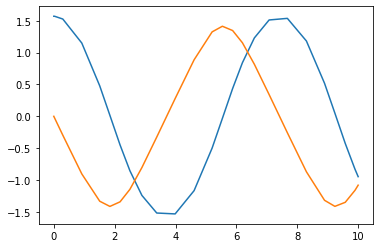

In [4]:
from scipy.integrate import solve_ivp

def pendulum(t,x):
    return np.array([x[1],-np.sin(x[0])])

sol = solve_ivp(pendulum,[0,10],[np.pi/2,0],rtol=1e-5)

plt.plot(sol.t,sol.y.T)


In [5]:
from numpy.random import randn
X = randn(2,1000)
Y = pendulum(0,X)
X,Y = X.T, Y.T
X.shape,Y.shape

((1000, 2), (1000, 2))

In [6]:
from torch.utils.data import DataLoader, random_split

class Dataset:
    def __init__(self,x,y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
        val_len = int(len(self) * 0.1)
        train_len = len(self) - val_len
        train, val = random_split(self, [train_len, val_len])
        self.train_loader = DataLoader(train, batch_size=32, num_workers=16)
        self.val_loader = DataLoader(val, batch_size=32, num_workers=16)
    def __getitem__(self,i):
        return self.x[i,:],self.y[i,:]
    def __len__(self):
        return self.x.shape[0]

dataset = Dataset(X,Y)

In [7]:
class NN(nn.Module):
    def __init__(self, arch=(10,10),activation='relu'):
        super().__init__()

        self.activation = {
            "relu": nn.ReLU,
            "softplus": nn.Softplus,
            "sigmoid": nn.Sigmoid,
        }[activation.lower()]

        self.model = nn.Sequential(
            nn.Linear(2,arch[0]),
            self.activation(),
            nn.Linear(arch[0],arch[1]),
            self.activation(),
            nn.Linear(arch[1],2)
        )

    def forward(self,x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x = x.view(x.size(0), -1)
        x_hat = self.forward(x)
        loss = self.compute_loss(x_hat, y)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.view(x.size(0), -1)
        x_hat = self.forward(x)
        loss = self.compute_loss(x_hat, y)
        return loss
        
    def compute_loss(self, x_hat, y):
        loss = F.mse_loss(x_hat, y)
        return loss
    

model = NN()
model

NN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [8]:
opt = model.configure_optimizers()

epochs = 10
for e in range(epochs):
    print(f"Epoch {e}")
    for batch, (x,y) in enumerate(dataset.train_loader):
        loss = model.training_step((x,y),batch)

        # Backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [9]:
[x for x in model.parameters()]

[Parameter containing:
 tensor([[ 0.6822,  0.2819],
         [ 0.3768, -0.2364],
         [ 0.5200,  0.4888],
         [-0.2402,  0.6180],
         [-0.2017, -0.6339],
         [ 0.8270, -0.6359],
         [ 0.5318,  0.3788],
         [-0.5028,  0.8142],
         [ 0.1372, -0.1269],
         [-0.0917,  0.0458]], requires_grad=True),
 Parameter containing:
 tensor([-0.1304, -0.6058,  0.0161,  0.4232,  0.0891, -0.2269,  0.5763, -0.3356,
          0.6152, -0.2955], requires_grad=True),
 Parameter containing:
 tensor([[-0.4393,  0.0813,  0.0423,  0.0977,  0.1765,  0.2682, -0.0218, -0.2916,
           0.1465, -0.3155],
         [ 0.3291, -0.1056,  0.2845,  0.3166, -0.1107,  0.0447,  0.2167,  0.2957,
           0.3086,  0.1017],
         [-0.2573, -0.1268,  0.2110, -0.3295,  0.3906,  0.4045,  0.1817,  0.1576,
           0.2033,  0.0505],
         [ 0.2677,  0.1674,  0.0359,  0.4713,  0.0247, -0.0676,  0.0350,  0.5083,
          -0.0998, -0.2608],
         [ 0.0704,  0.1570, -0.3151,  0.1118,

In [10]:
# First two modules are just containers

ls = [*model.modules()]
ls

[NN(
   (model): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): ReLU()
     (2): Linear(in_features=10, out_features=10, bias=True)
     (3): ReLU()
     (4): Linear(in_features=10, out_features=2, bias=True)
   )
 ),
 Sequential(
   (0): Linear(in_features=2, out_features=10, bias=True)
   (1): ReLU()
   (2): Linear(in_features=10, out_features=10, bias=True)
   (3): ReLU()
   (4): Linear(in_features=10, out_features=2, bias=True)
 ),
 Linear(in_features=2, out_features=10, bias=True),
 ReLU(),
 Linear(in_features=10, out_features=10, bias=True),
 ReLU(),
 Linear(in_features=10, out_features=2, bias=True)]

In [11]:
# This is how we can extract the weights

[*ls[2].parameters()][0].detach().numpy(),[*ls[2].parameters()][1].detach().numpy()

(array([[ 0.6821918 ,  0.2819293 ],
        [ 0.37681815, -0.23642713],
        [ 0.5200389 ,  0.48878354],
        [-0.24023256,  0.6179663 ],
        [-0.20165955, -0.6339482 ],
        [ 0.8269567 , -0.63592243],
        [ 0.5318363 ,  0.37878066],
        [-0.50276935,  0.8142358 ],
        [ 0.13723241, -0.12690513],
        [-0.09171999,  0.04578549]], dtype=float32),
 array([-0.1303787 , -0.6057688 ,  0.01610511,  0.423187  ,  0.08913533,
        -0.22690648,  0.57627094, -0.33555195,  0.61518437, -0.29546094],
       dtype=float32))

In [12]:
def convert_model_to_layer_struct(model):
        net = []
        for i, layer in enumerate(model.modules()):
            if isinstance(layer,nn.Sequential) or isinstance(layer,NN):
                continue
            elif isinstance(layer,nn.Linear):
                weights = [*layer.parameters()]
                net.append({
                    'type': 'dense', 
                    'activation': 'none', 
                    'W': weights[0].detach().numpy().tolist(),
                    'b':weights[1].detach().numpy().tolist(),
                })
            elif isinstance(layer,nn.ReLU):
                net[-1]['activation'] = 'relu'
            elif isinstance(layer,nn.Dropout):
                pass
            else:
                raise "Unparseable layer type"
        return net

model_json = convert_model_to_layer_struct(model)
model_json

[{'type': 'dense',
  'activation': 'relu',
  'W': [[0.682191789150238, 0.2819293141365051],
   [0.37681815028190613, -0.23642712831497192],
   [0.520038902759552, 0.4887835383415222],
   [-0.24023255705833435, 0.6179662942886353],
   [-0.20165954530239105, -0.6339482069015503],
   [0.8269566893577576, -0.6359224319458008],
   [0.5318362712860107, 0.37878066301345825],
   [-0.5027693510055542, 0.8142358064651489],
   [0.13723240792751312, -0.12690512835979462],
   [-0.09171998500823975, 0.045785486698150635]],
  'b': [-0.13037869334220886,
   -0.6057687997817993,
   0.016105106100440025,
   0.4231869876384735,
   0.08913532644510269,
   -0.22690647840499878,
   0.5762709379196167,
   -0.3355519473552704,
   0.6151843667030334,
   -0.29546093940734863]},
 {'type': 'dense',
  'activation': 'relu',
  'W': [[-0.4392658770084381,
    0.0813082605600357,
    0.04228625446557999,
    0.09774034470319748,
    0.17646636068820953,
    0.2681753635406494,
    -0.021846385672688484,
    -0.2915913

In [13]:
# Since we're passing it to MATLAB, we save to weights to a file
import os
import json

os.makedirs('weights',exist_ok=True)
model_path = 'weights/model.json'

with open(model_path,'w') as f:
    json.dump(model_json,f)


# Setting up the MATLAB engine

In [14]:
# Start MATLAB

import matlab.engine as mtlb

eng = mtlb.start_matlab()
eng

In [49]:
# Plots don't work when the default figure style is 'docked', so we take care of that here
# f = eng.figure('WindowStyle','normal')
eng.set(eng.groot(),'DefaultFigureWindowStyle','normal')

matlab.double([])

(-0.5, 1166.5, 874.5, -0.5)

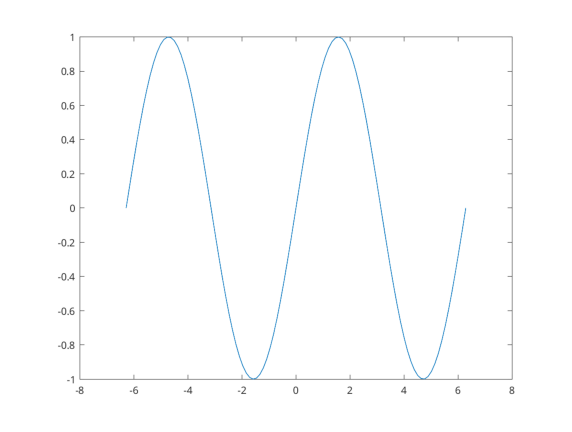

In [50]:
# We need to save the MATLAB figure as a file again in order to plot here.
x = eng.linspace(-2*np.pi,2*np.pi,100)
h = eng.line(x,eng.sin(x))
eng.saveas(h,'output/test.png',nargout=0)

plt.figure(figsize=(10,10))
plt.imshow(plt.imread('output/test.png'))
plt.axis('off')


In [77]:
# We can make a function to handle these temp files
# If you specify a path then this also saves the figure

def show_fig(path='output/temp.png'):
    eng.saveas(eng.gcf(),path,nargout=0)
    plt.imshow(plt.imread(path))
    plt.axis('off')


# Computing the PWA regions and plotting them

In [18]:
# Initialise the MATLAB path
eng.pwlregions_init(nargout=0)

In [19]:
# We just need to pass in the path of our JSON model to create a Network object
net = eng.PWANetwork(model_path)


In [57]:
# In order to effectively compute the regions, we need an initial region.
# Here I just specify a 2-dim box with side length 10.
# IMPORTANT: make a new initial region every time you call pwa(). The code uses the 
# initial region as the root of the tree
box = eng.makebox(2.,10.)
eng.pwa(net, 'input_space',box)
regions = eng.getfield(net,'regions')

> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot_internal (line 199)
In ConvexSet/plot (line 154)
> In Polyhedron/plot

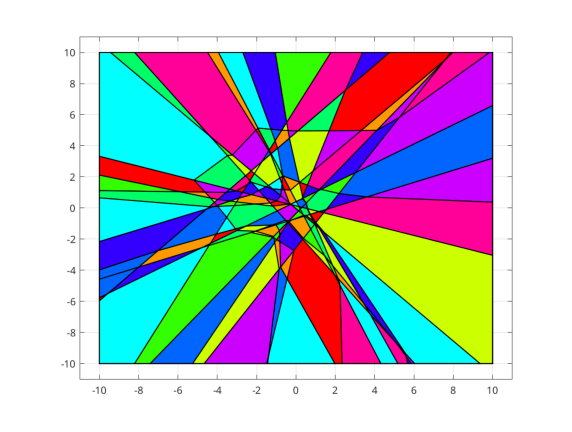

In [63]:
regions_plot_path = 'output/regions.png'
eng.plot(regions)
show_fig()

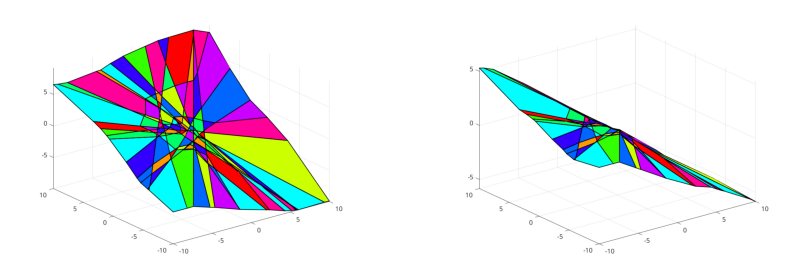

In [81]:
# We can also plot the outputs of the network
plt.figure(figsize=(14,14))
plt.subplot(1,2,1)
eng.plot_output(net,1,nargout=0)
show_fig()

plt.subplot(1,2,2)
eng.plot_output(net,2,nargout=0)
show_fig()

In [69]:
eng.clear('all',nargout=0)